# PROJE: UÇAKLARIN KALKIŞ YAPMADAN ÖNCE KAÇ DAKİKA GEÇ KALABİLECEĞİNİ TAHMİN ETME

## VERİ SETİNİ İNDİRMEK VE GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ

In [158]:

import numpy as np #veri işleme için
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt #grafik tasarımı için
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder #label encoding işlemi yapmak için
from sklearn.preprocessing import StandardScaler #standart normal dağılım yapmak için
from sklearn.ensemble import RandomForestRegressor #model eğitmek için
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #değerlendirme için


file = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file +=os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))


/kaggle/input/flight-dataset/flights.csv


## VERİ SETİNİ İNCELEME

**Temel Özellikler**

* Tarih ve Saat Bilgileri: Yıl, Ay, Gün, Saat, Dakika ve Uçuş Saati
* Uçuş Ayrıntıları: Kalkış ve Varış Saatleri, Gecikmeler (hem kalkış hem de varış), Taşıyıcı, Uçuş Numarası, Kuyruk Numarası
* Uçuşun Başlangıcı ve Varış Noktası: İlgili havaalanları (örneğin, EWR, JFK, ATL)
* Uçuş Performansı Ölçümleri: Hava Süresi, Mesafe ve Gecikme süreleri
* Planlanan ve Gerçek Zamanlar: Kalkış ve Varış programı ve gerçek zamanları


In [159]:
df = pd.read_csv(file)
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,628,N25201,EWR,SMF,367.0,2500.0,20.0,38.0,2023-01-01 20:00:00
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,393,N830DN,JFK,ATL,108.0,760.0,23.0,0.0,2023-01-01 23:00:00
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,371,N807JB,JFK,BQN,190.0,1576.0,23.0,44.0,2023-01-01 23:00:00
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,1053,N265JB,JFK,CHS,108.0,636.0,21.0,40.0,2023-01-01 21:00:00
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,219,N17730,EWR,DTW,80.0,488.0,20.0,48.0,2023-01-01 20:00:00


**Veri setimiz 435352 satır ve 19 sütundan oluşmaktadır. Yukarıda veri setinin ilk 5 satırını görüyoruz.** Kolonlarımızdaki **year, month, day** alanları kalkışın gerçekleştiği yıl, ay ve gün bilgisini vermektedir. **dep_time** kalkışın gerçekleştiği saat bilgisini farklı bir formatta vermektedir. Örneğin 1.0 değeri 00:01 de kalkışın gerçekleştiğini söylemektedir. aynı şekilde **sched_dep_time** planlanan kalkış saatini, **arr_time** varış saatini, **sched_arr_time** planlanan varış saatini belirtirken formatları dep_time ile aynıdır. **carrier** kolonu havayolu kodu bilgisini, **flight** uçuş numarasını, **tailnum** uçağın kuyruk numarasını, **origin** kalkış havaalanı kodunu, **dest** varış havaalanı kodu bilgisini vermektedir. **dep_delay** uçağın ne kadar geciktiğini dk cinsinden vermektedir aynı şekilde **arr_delay** varış süresinin ne kadar geciktiği bilgisini dk cinsinden vermektedir. **air_time** uçuş süresini dk cinsinden, **distance** ise mesafeyi mil cinsinden ifade etmektedir.

* Uçuşların gecikmesinin tahmini için **sched_dep_time, sched_arr_time, arr_delay, air_time ve distance** gibi sayısal değişkenlere; **carrier, origin, dest** gibi kategorik değişkenlere ihtiyacım var.

In [160]:
df.count()

year              435352
month             435352
day               435352
dep_time          424614
sched_dep_time    435352
dep_delay         424614
arr_time          423899
sched_arr_time    435352
arr_delay         422818
carrier           435352
flight            435352
tailnum           433439
origin            435352
dest              435352
air_time          422818
distance          435352
hour              435352
minute            435352
time_hour         435352
dtype: int64

In [161]:
df.isnull().sum()

year                  0
month                 0
day                   0
dep_time          10738
sched_dep_time        0
dep_delay         10738
arr_time          11453
sched_arr_time        0
arr_delay         12534
carrier               0
flight                0
tailnum            1913
origin                0
dest                  0
air_time          12534
distance              0
hour                  0
minute                0
time_hour             0
dtype: int64

Yukarıda görüldüğü gibi her sütun için veri sayısı aynı değil bu da eksik verilerin olduğunu gösteriyor. Model oluşturmak için öncelikle veri setini düzenlememiz gerekiyor.

In [162]:
# eksik verisi olan satırları silme işlemi gerçekleştirelim
df.dropna(inplace=True)
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,628,N25201,EWR,SMF,367.0,2500.0,20.0,38.0,2023-01-01 20:00:00
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,393,N830DN,JFK,ATL,108.0,760.0,23.0,0.0,2023-01-01 23:00:00
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,371,N807JB,JFK,BQN,190.0,1576.0,23.0,44.0,2023-01-01 23:00:00
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,1053,N265JB,JFK,CHS,108.0,636.0,21.0,40.0,2023-01-01 21:00:00
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,219,N17730,EWR,DTW,80.0,488.0,20.0,48.0,2023-01-01 20:00:00


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422818 entries, 0 to 435351
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            422818 non-null  int64  
 1   month           422818 non-null  int64  
 2   day             422818 non-null  int64  
 3   dep_time        422818 non-null  float64
 4   sched_dep_time  422818 non-null  int64  
 5   dep_delay       422818 non-null  float64
 6   arr_time        422818 non-null  float64
 7   sched_arr_time  422818 non-null  int64  
 8   arr_delay       422818 non-null  float64
 9   carrier         422818 non-null  object 
 10  flight          422818 non-null  int64  
 11  tailnum         422818 non-null  object 
 12  origin          422818 non-null  object 
 13  dest            422818 non-null  object 
 14  air_time        422818 non-null  float64
 15  distance        422818 non-null  float64
 16  hour            422818 non-null  float64
 17  minute         

# **Verileri Dönüştürme**
* Saat verileri farklı formattaydı. Örneğin 36.0 olarak girilmişse 00.36 demektir. Bunu düzeltme işlemine tabi tutmamız gerekir.
* Saat verilerini saat formatına koyma işlemi:

In [164]:
# saat formatına çevirme fonksiyonu:
def convert_to_time(deger):
    if pd.isna(deger):
        return pd.NaT #Not a Time yani zaman için eksik değer karşılığıdır.
    deger = int(deger)
    hour = deger // 100
    minute = deger % 100

    if hour == 24: #farklı girişleri tek formata koymak için
        hour = 0
    if hour > 23 or minute > 59:
        return pd.NaT
    return pd.to_datetime(f'{hour:02d}:{minute:02d}', format='%H:%M').time()

#uygulama:
df['sched_dep_time_clean'] = df['sched_dep_time'].apply(convert_to_time)
df['dep_time_clean'] = df['dep_time'].apply(convert_to_time)
df['sched_arr_time_clean'] = df['sched_arr_time'].apply(convert_to_time)
df['arr_time_clean'] = df['arr_time'].apply(convert_to_time)

In [165]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,sched_dep_time_clean,dep_time_clean,sched_arr_time_clean,arr_time_clean
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,...,SMF,367.0,2500.0,20.0,38.0,2023-01-01 20:00:00,20:38:00,00:01:00,00:03:00,03:28:00
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,...,ATL,108.0,760.0,23.0,0.0,2023-01-01 23:00:00,23:00:00,00:18:00,01:35:00,02:28:00
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,...,BQN,190.0,1576.0,23.0,44.0,2023-01-01 23:00:00,23:44:00,00:31:00,04:26:00,05:00:00
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,...,CHS,108.0,636.0,21.0,40.0,2023-01-01 21:00:00,21:40:00,00:33:00,23:52:00,02:38:00
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,...,DTW,80.0,488.0,20.0,48.0,2023-01-01 20:00:00,20:48:00,00:36:00,22:52:00,02:23:00


* Uçuş tarihini modele direkt vermek yerine haftanın hangi gününe denk geldiğini çekebilirsek daha sağlıklı sonuç elde edebiliriz.
*  Bu nedenle **day_of_week** kolonu ekleyerek günlere ait sayılar vereceğim ancak öncelikle uçuş tarihinin olduğu year, month ve day kolonlarını birleştirmem lazım. Hata almamak için öncelikle null kontrolü yapıp daha sonra birleştirme işlemini yapacağım.

In [166]:
df[['year', 'month', 'day']].isnull().sum()

year     0
month    0
day      0
dtype: int64

In [167]:
df['flight_date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['day_of_week'] = df['flight_date'].dt.dayofweek

#doğru çalışıp çalışmadığını kontrol ediyorum
df['day_of_week'].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int32)

In [168]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,distance,hour,minute,time_hour,sched_dep_time_clean,dep_time_clean,sched_arr_time_clean,arr_time_clean,flight_date,day_of_week
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,...,2500.0,20.0,38.0,2023-01-01 20:00:00,20:38:00,00:01:00,00:03:00,03:28:00,2023-01-01,6
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,...,760.0,23.0,0.0,2023-01-01 23:00:00,23:00:00,00:18:00,01:35:00,02:28:00,2023-01-01,6
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,...,1576.0,23.0,44.0,2023-01-01 23:00:00,23:44:00,00:31:00,04:26:00,05:00:00,2023-01-01,6
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,...,636.0,21.0,40.0,2023-01-01 21:00:00,21:40:00,00:33:00,23:52:00,02:38:00,2023-01-01,6
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,...,488.0,20.0,48.0,2023-01-01 20:00:00,20:48:00,00:36:00,22:52:00,02:23:00,2023-01-01,6


* Uçuş gecikmesi için **carrier** kolonu uçuşu yapan uçakların bağlı olduğu taşımacı bilgisini taşır.
* **origin** kolonu uçağın kalktığı konumun bilgisi vardır. **dest** kolonu ise varış noktası bilgisini taşır.
* Uçuş gecikmesine etki edeceğini düşündüğüm değerleri string olan kolonları **LABEL ENCODING** ile sayısallaştırma:

In [169]:
df['carrier'].unique()

array(['UA', 'DL', 'B6', 'AA', 'NK', 'WN', 'AS', 'YX', '9E', 'HA', 'G4',
       'MQ', 'OO', 'F9'], dtype=object)

In [170]:
df['carrier_encoded'] = LabelEncoder().fit_transform(df['carrier'])
print(df[['carrier', 'carrier_encoded']].head())

  carrier  carrier_encoded
0      UA               11
1      DL                4
2      B6                3
3      B6                3
4      UA               11


In [171]:
df['origin'].unique()

array(['EWR', 'JFK', 'LGA'], dtype=object)

In [172]:
df['origin_encoded'] = LabelEncoder().fit_transform(df['origin'])
print(df[['origin', 'origin_encoded']].head())

  origin  origin_encoded
0    EWR               0
1    JFK               1
2    JFK               1
3    JFK               1
4    EWR               0


In [173]:
df['dest'].unique()

array(['SMF', 'ATL', 'BQN', 'CHS', 'DTW', 'MIA', 'ORD', 'IAH', 'FLL',
       'PBI', 'MCO', 'BNA', 'DEN', 'MSP', 'HOU', 'MDW', 'MYR', 'SEA',
       'CLE', 'SJU', 'PHX', 'LAS', 'STT', 'TPA', 'RSW', 'DAL', 'IAD',
       'SLC', 'STL', 'BZN', 'DFW', 'LAX', 'SFO', 'DCA', 'SNA', 'BOS',
       'SAN', 'SDF', 'CLT', 'PWM', 'RDU', 'SRQ', 'SYR', 'MSY', 'AUS',
       'JAX', 'SAT', 'EGE', 'PHL', 'PIT', 'CVG', 'AVL', 'OGG', 'CMH',
       'SAV', 'BUR', 'PVD', 'EYW', 'BTV', 'GSP', 'IND', 'HNL', 'MCI',
       'MKE', 'JAC', 'MEM', 'BGR', 'ILM', 'MSN', 'BUF', 'ORF', 'GRR',
       'OMA', 'PDX', 'MTJ', 'RIC', 'ORH', 'TYS', 'GSO', 'OKC', 'BWI',
       'MHT', 'ROC', 'CHO', 'ALB', 'XNA', 'OAK', 'LIT', 'MDT', 'TUL',
       'PSP', 'ONT', 'RNO', 'PSE', 'HDN', 'ROA', 'DAY', 'BDL', 'DSM',
       'ITH', 'VPS', 'BHM', 'CAE', 'SCE', 'BGM', 'LEX', 'HHH', 'AVP',
       'SJC', 'ABQ', 'AGS', 'ACK', 'MVY', 'HYA', 'PNS', 'TVC', 'ANC',
       'SBN'], dtype=object)

In [174]:
df['dest_encoded'] = LabelEncoder().fit_transform(df['dest'])
print(df[['dest', 'dest_encoded']].head())

  dest  dest_encoded
0  SMF           106
1  ATL             5
2  BQN            15
3  CHS            23
4  DTW            34


In [175]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,time_hour,sched_dep_time_clean,dep_time_clean,sched_arr_time_clean,arr_time_clean,flight_date,day_of_week,carrier_encoded,origin_encoded,dest_encoded
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,...,2023-01-01 20:00:00,20:38:00,00:01:00,00:03:00,03:28:00,2023-01-01,6,11,0,106
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,...,2023-01-01 23:00:00,23:00:00,00:18:00,01:35:00,02:28:00,2023-01-01,6,4,1,5
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,...,2023-01-01 23:00:00,23:44:00,00:31:00,04:26:00,05:00:00,2023-01-01,6,3,1,15
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,...,2023-01-01 21:00:00,21:40:00,00:33:00,23:52:00,02:38:00,2023-01-01,6,3,1,23
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,...,2023-01-01 20:00:00,20:48:00,00:36:00,22:52:00,02:23:00,2023-01-01,6,11,0,34


* Verileri düzenleme işlemini büyük ölçüde yaptım. bu durumda kullanılacak kolonlar: **sched_arr_time_clean, sched_dep_time_clean, day_of_week, carrier_encoded, origin_encoded, dest_encoded, dep_delay, arr_delay, distance, air_time** dir.

# AYKIRI DEĞER TESPİTİ
Aykırı değer analizi yapacağım ve bunu yaparken en sık kullanılan yöntemlerden biri olan **Boxplot (kutu grafik)** yöntemini kullanacağım.

**1- distance kolonunda** aykırı değer tespiti:

In [176]:
df_distance = df["distance"]
df_distance.head()

0    2500.0
1     760.0
2    1576.0
3     636.0
4     488.0
Name: distance, dtype: float64

<Axes: xlabel='distance'>

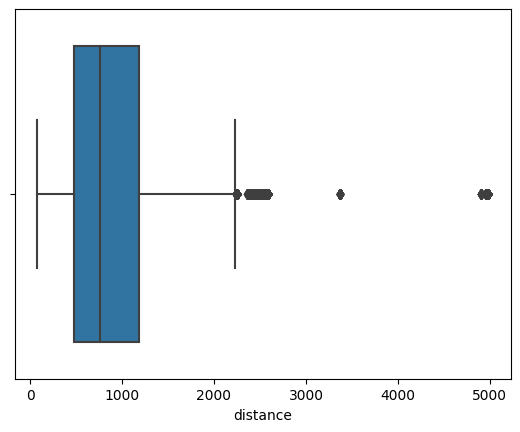

In [177]:
sns.boxplot(x = df_distance)

In [178]:
Q1 = df_distance.quantile(0.25)
Q3 = df_distance.quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}  Q3: {Q3}  IQR: {IQR}")

Q1: 479.0  Q3: 1183.0  IQR: 704.0


In [179]:
alt_sinir = Q1 - 0.65*IQR
ust_sinir = Q3 + 1.5*IQR
print(f"ALT SINIR: {alt_sinir} ÜST SINIR: {ust_sinir}")

ALT SINIR: 21.399999999999977 ÜST SINIR: 2239.0


In [180]:
aykirilar = (df_distance < alt_sinir) | (df_distance > ust_sinir)
print("Aykırı değer sayısı:", aykirilar.sum())

Aykırı değer sayısı: 45828


* Aykırı değer sayısı fazla olduğu için silme işlemini uygulamıyorum.
* Gidilecek yer  uzak olabilir bu yüzden aykırı değer olması çok normal bu nedenle bu kolona müdahale etmiyorum.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


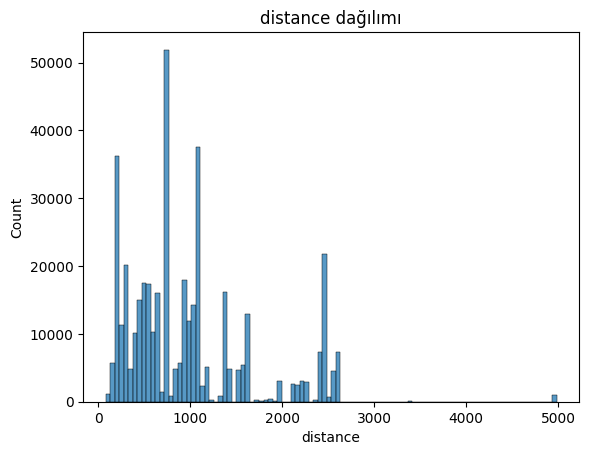

In [181]:
sns.histplot(df['distance'], bins=100)
plt.title("distance dağılımı")
plt.show()

**2- dep_delay kolonunun** aykırı değer tespiti:

In [182]:
df_dep_delay = df["dep_delay"]
df_dep_delay.head()

0    203.0
1     78.0
2     47.0
3    173.0
4    228.0
Name: dep_delay, dtype: float64

<Axes: xlabel='dep_delay'>

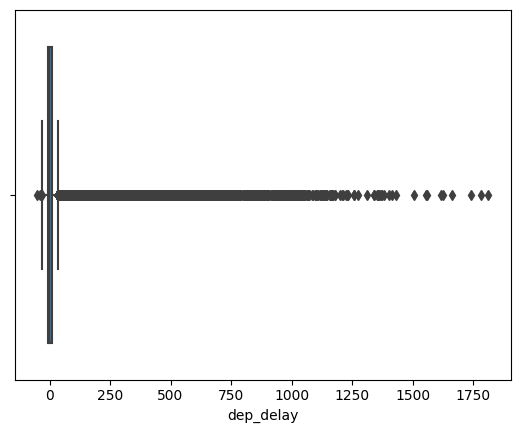

In [183]:
sns.boxplot(x=df_dep_delay)

In [184]:
Q1 = df_dep_delay.quantile(0.25)
Q3 = df_dep_delay.quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}  Q3: {Q3}  IQR: {IQR}")

Q1: -6.0  Q3: 10.0  IQR: 16.0


In [185]:
alt_sinir = Q1 - 0.5*IQR
ust_sinir = Q3 + 3*IQR
print(f"ALT SINIR: {alt_sinir} ÜST SINIR: {ust_sinir}")

ALT SINIR: -14.0 ÜST SINIR: 58.0


In [186]:
aykirilar = (df_dep_delay < alt_sinir) | (df_dep_delay > ust_sinir)
print("Aykırı değer sayısı:", aykirilar.sum())

Aykırı değer sayısı: 38085


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


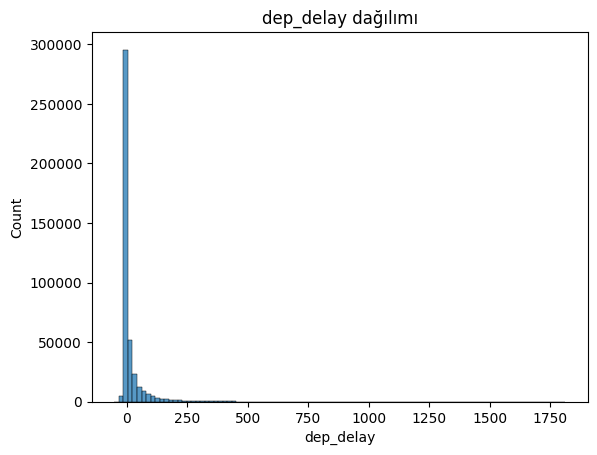

In [187]:
sns.histplot(df['dep_delay'], bins=100)
plt.title("dep_delay dağılımı")
plt.show()

* **dep_delay** in aykırı değerlerine müdahale edip aykırı değerlerin eşik değerler arasında olmasını sağlamıştım ancak modelin performansını olumsuz etkiledi. Daha sonra aykırı değerler olsa da gerçek hali ile kalması gerektiğinin daha doğru sonuçlar verdiğini gördüm. Bu nedenle kolona müdahale etmemeyi tercih ettim.

**3- arr_delay kolonunun** aykırı değerlerini inceleme:

In [188]:
df_arr_delay = df["arr_delay"]
df_arr_delay.head()

0    205.0
1     53.0
2     34.0
3    166.0
4    211.0
Name: arr_delay, dtype: float64

<Axes: xlabel='arr_delay'>

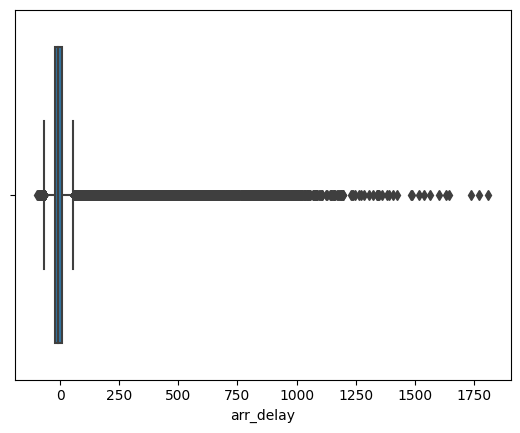

In [189]:
sns.boxplot( x=df_arr_delay)

In [190]:
Q1=df_arr_delay.quantile(0.25)
Q3=df_arr_delay.quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}  Q3: {Q3}  IQR: {IQR}")

Q1: -22.0  Q3: 9.0  IQR: 31.0


In [191]:
alt_sinir = Q1 - 0.5*IQR
ust_sinir = Q3 + 3*IQR
print(f"ALT SINIR: {alt_sinir} ÜST SINIR: {ust_sinir}")

ALT SINIR: -37.5 ÜST SINIR: 102.0


In [192]:
aykirilar = (df_arr_delay < alt_sinir) | (df_arr_delay > ust_sinir)
print("Aykırı değer sayısı:", aykirilar.sum())

Aykırı değer sayısı: 37440


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


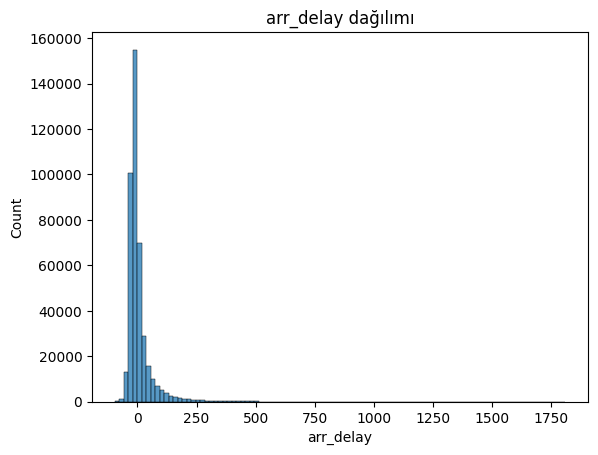

In [193]:
sns.histplot(df['arr_delay'], bins=100)
plt.title("arr_delay dağılımı")
plt.show()

* **arr_delay** in aykırı değerlerini yine eşik değerler arasında olmasını sağlamıştım ancak orijinal hali ile daha iyi sonuç verdiği için o kısmı düzenledim.

**4- air_time kolonunun** aykırı değer tespiti:

In [194]:
df_air_time = df["air_time"]
df_air_time.head()

0    367.0
1    108.0
2    190.0
3    108.0
4     80.0
Name: air_time, dtype: float64

<Axes: xlabel='air_time'>

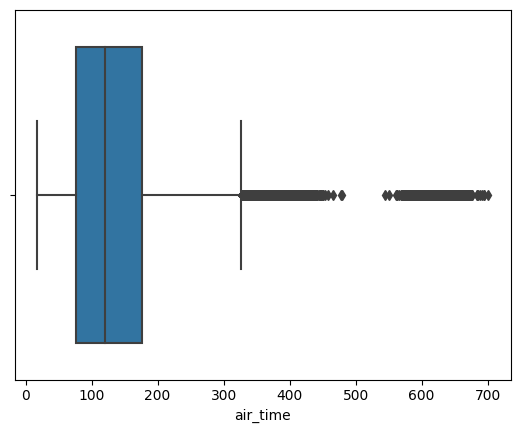

In [195]:
sns.boxplot(x=df_air_time)

In [196]:
Q1 = df_air_time.quantile(0.25)
Q3 = df_air_time.quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}  Q3: {Q3}  IQR: {IQR}")

Q1: 77.0  Q3: 177.0  IQR: 100.0


In [197]:
alt_sinir = Q1 - 0.75*IQR
ust_sinir = Q3 + 1.5*IQR
print(f"ALT SINIR: {alt_sinir} ÜST SINIR: {ust_sinir}")

ALT SINIR: 2.0 ÜST SINIR: 327.0


In [198]:
aykirilar = (df_air_time < alt_sinir) | (df_air_time > ust_sinir)
print("Aykırı değer sayısı:", aykirilar.sum())

Aykırı değer sayısı: 22988


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


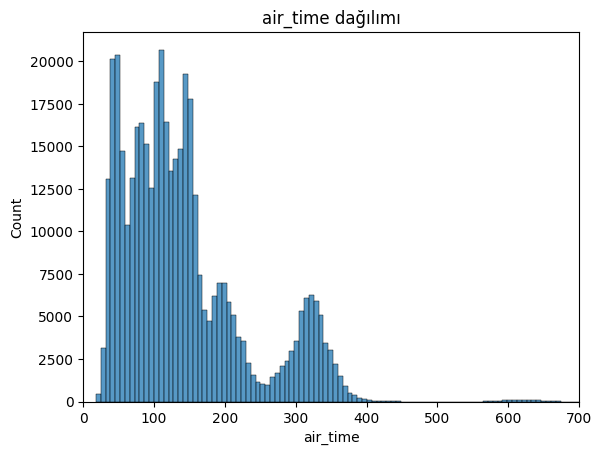

In [199]:
sns.histplot(df['air_time'], bins=100)
plt.xlim(0, 700) 
plt.title("air_time dağılımı")
plt.show()

* Bir uçak kısa mesafe uçabilir veya uzun mesafe uçabilir. Negatif uçuş zamanı olmadığı için de bu kolona müdahale etmiyorum.

# MODEL OLUŞTURMA

* **Regresyon** problemi üzerinde çalışacağım.
* Yaklaşık 435 bin veri var.
* Verilerde doğrusal bir ilişki olduğunu düşündüğüm için ilk olarak **LINEER REGRESYON** kullandım ancak **RANDOM FOREST** daha iyi sonuç vedi bu nedenle modeli eğitirken bu algoritmayı kullandım.

In [200]:
#Değerlendirilecek kolonları belirleme:
x = df[['arr_delay','sched_dep_time_clean', 'sched_arr_time_clean',
        'air_time', 'day_of_week','carrier_encoded',
        'origin_encoded', 'dest_encoded','distance']]

y = df['dep_delay']


In [201]:
# veri setini %20 test %80 train olarak bölme işlemi
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

#datetime türündeki verileri second haline çevirme fonksiyonu:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

#uygulama:
x_train['sched_dep_time_clean_sec'] = x_train['sched_dep_time_clean'].apply(time_to_seconds)
x_test['sched_dep_time_clean_sec'] = x_test['sched_dep_time_clean'].apply(time_to_seconds)

# Orijinal zaman sütununu çıkarma işlemi
x_train = x_train.drop(columns=['sched_dep_time_clean'])
x_test = x_test.drop(columns=['sched_dep_time_clean'])


x_train['sched_arr_time_clean_sec'] = x_train['sched_arr_time_clean'].apply(time_to_seconds)
x_test['sched_arr_time_clean_sec'] = x_test['sched_arr_time_clean'].apply(time_to_seconds)

# Orijinal zaman sütununu çıkarma işlemi
x_train = x_train.drop(columns=['sched_arr_time_clean'])
x_test = x_test.drop(columns=['sched_arr_time_clean'])

* Saat formatı ile işlem yapılamadığı için saniyeye çevirdim.

In [202]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

* Yukarıdaki işlem ile her değişkenin ortalaması 0,Standart sapması 1 olacak şekilde dönüştürülerek **standart normal dağılıma** sahip olması sağlanır. Ve öğrenme sağlanır.

In [203]:
# Modeli oluşturma (Random Forest):
#n_estimators: Kaç adet karar ağacı kullanılacağını belirler.
#random_state:Model her çalıştırıldığında aynı sonucu vermesini sağlar.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)#100 adet ağaç

# Eğitme:
rf_model.fit(x_train, y_train)

# Test et:
y_pred = rf_model.predict(x_test)

# Performans ölçme metrikleri:
#MAE:Ortalama mutlak hata
mae = mean_absolute_error(y_test, y_pred)
#MSE:Hatanın karesi alınır
mse = mean_squared_error(y_test, y_pred)
#RMSE:Karekök ortalama hata
rmse = np.sqrt(mse)
#R2:Varyans oranı
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 7.229883387936477
MSE: 149.18471977081978
RMSE: 12.214119688738103
R² Score: 0.947966803206839


* Random forest tan önce lineer regresyon denemiştim ancak küçük fark olsa da random forest daha iyi sonuç verdi.

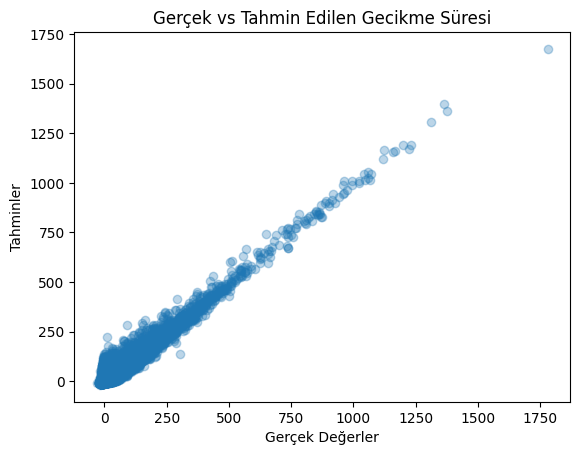

In [204]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahminler")
plt.title("Gerçek vs Tahmin Edilen Gecikme Süresi")
plt.show()